In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from sentence_transformers import SentenceTransformer

print("Libraries imported successfully!")


Libraries imported successfully!


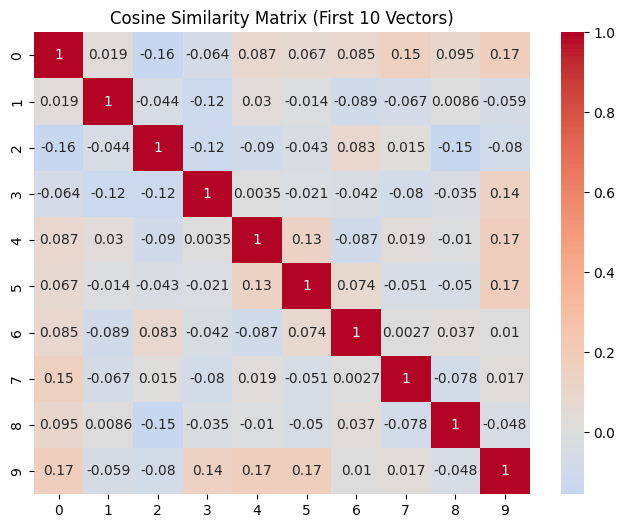

Top 5 most similar vectors to vector 0:
1. Vector 495: similarity = 0.2895
2. Vector 410: similarity = 0.2788
3. Vector 840: similarity = 0.2669
4. Vector 587: similarity = 0.2663
5. Vector 931: similarity = 0.2606

Distance metrics between vector 0 and 1:
Euclidean distance: 15.7580
Cosine distance: 0.9811
Manhattan distance: 142.3804


In [8]:
# Create some sample vectors
vectors = np.random.randn(1000, 128)  # 1000 vectors of dimension 128

# Normalize vectors for cosine similarity
vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

# Compute cosine similarity matrix for first 10 vectors
similarity_matrix = cosine_similarity(vectors_normalized[:10])

# Visualize similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Cosine Similarity Matrix (First 10 Vectors)')
plt.show()

# Find most similar vectors to the first one
query_vector = vectors_normalized[0]
similarities = cosine_similarity([query_vector], vectors_normalized[1:])[0]
top_5_indices = np.argsort(similarities)[-5:][::-1]

print("Top 5 most similar vectors to vector 0:")
for i, idx in enumerate(top_5_indices):
    print(f"{i+1}. Vector {idx+1}: similarity = {similarities[idx]:.4f}")

# Demonstrate different distance metrics
from scipy.spatial.distance import euclidean, cosine, cityblock

vec1 = vectors[0]
vec2 = vectors[1]

print(f"\nDistance metrics between vector 0 and 1:")
print(f"Euclidean distance: {euclidean(vec1, vec2):.4f}")
print(f"Cosine distance: {cosine(vec1, vec2):.4f}")
print(f"Manhattan distance: {cityblock(vec1, vec2):.4f}")


In [9]:
# Generate larger dataset for FAISS demo
d = 128  # dimension
nb = 100000  # database size
nq = 5  # number of queries

print(f"Creating dataset: {nb} vectors of dimension {d}")

# Generate random data
np.random.seed(1234)
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.  # Make data slightly structured

# Generate queries
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

print("Data generated!")

# Build FAISS index (L2 distance)
index = faiss.IndexFlatL2(d)
print(f"Index is trained: {index.is_trained}")

# Add vectors to index
index.add(xb)
print(f"Index total: {index.ntotal}")

# Search
k = 5  # we want 5 nearest neighbors
print(f"\nSearching for {k} nearest neighbors...")

distances, indices = index.search(xq, k)

print(f"Query results shape: {indices.shape}")
print("\nFirst query results:")
for i in range(k):
    print(f"  Neighbor {i+1}: index {indices[0, i]}, distance {distances[0, i]:.4f}")

# Build a more efficient index (IVF - Inverted File)
nlist = 100  # number of clusters
quantizer = faiss.IndexFlatL2(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)

print(f"\nTraining IVF index with {nlist} clusters...")
index_ivf.train(xb)
index_ivf.add(xb)

# Search with IVF index
index_ivf.nprobe = 10  # number of clusters to search
distances_ivf, indices_ivf = index_ivf.search(xq, k)

print("IVF Index search results:")
for i in range(k):
    print(f"  Neighbor {i+1}: index {indices_ivf[0, i]}, distance {distances_ivf[0, i]:.4f}")

# Compare performance (timing)
import time

# Time flat index
start_time = time.time()
for _ in range(100):
    _, _ = index.search(xq, k)
flat_time = time.time() - start_time

# Time IVF index
start_time = time.time()
for _ in range(100):
    _, _ = index_ivf.search(xq, k)
ivf_time = time.time() - start_time

print(f"\nPerformance comparison (100 searches):")
print(f"Flat index: {flat_time:.4f} seconds")
print(f"IVF index: {ivf_time:.4f} seconds")
print(f"Speedup: {flat_time/ivf_time:.2f}x")


Creating dataset: 100000 vectors of dimension 128
Data generated!
Index is trained: True
Index total: 100000

Searching for 5 nearest neighbors...
Query results shape: (5, 5)

First query results:
  Neighbor 1: index 715, distance 15.2916
  Neighbor 2: index 286, distance 15.7526
  Neighbor 3: index 11, distance 16.0573
  Neighbor 4: index 1332, distance 16.2048
  Neighbor 5: index 544, distance 16.3616

Training IVF index with 100 clusters...
IVF Index search results:
  Neighbor 1: index 715, distance 15.2916
  Neighbor 2: index 286, distance 15.7526
  Neighbor 3: index 11, distance 16.0573
  Neighbor 4: index 1332, distance 16.2048
  Neighbor 5: index 544, distance 16.3616

Performance comparison (100 searches):
Flat index: 0.1256 seconds
IVF index: 0.0126 seconds
Speedup: 9.96x
